# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [1]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,40 mins 06 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,3 months and 4 days
H2O cluster name:,H2O_from_python_ngill_wy2yk6
H2O cluster total nodes:,1
H2O cluster free memory:,28.42 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


# Helper functions

In [2]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [3]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[2]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

In [4]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

In [5]:
# Load in train and test data used for modelling
train_path = os.sep.join(['..', 'data', 'output', 'train_simulated_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'test_simulated_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
# Inputs and output
X = ['binary1',
'binary2',
'cat1_0',
'cat1_1',
'cat1_2',
'cat1_3',
'cat1_4',
'fried1_std',
'fried2_std',
'fried3_std',
'fried4_std',
'fried5_std']
fold_column = 'fold'
Y = "outcome"

In [7]:
# Load in models
mgbm = h2o.load_model('../models/MGBM_BEST_GRID_v2_SIMULATED_1575932311.860524/mgbm_grid2_simulated_model_20') 
gbm = h2o.load_model('../models/GBM_BEST_GRID_v2_SIMULATED_1575932627.142728/gbm_grid2_simulated_model_12')
mxgb = h2o.load_model('../models/MXGB_BEST_GRID_v2_SIMULATED_1575933183.1382315/mxgb_grid2_simulated_model_12')
xgb = h2o.load_model('../models/XGB_BEST_GRID_v2_SIMULATED_1575934130.1232975/xgb_grid2_simulated_model_24')

In [8]:
# Check performance across all models on test set
print(f"Test AUC for Constrained H2O GBM: {mgbm.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O GBM: {gbm.model_performance(test).auc()}\n")
print(f"Test AUC for Constrained H2O XGBoost: {mxgb.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O XGBoost: {xgb.model_performance(test).auc()}\n")

print(f"Test Logloss for Constrained H2O GBM: {mgbm.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O GBM: {gbm.model_performance(test).logloss()}\n")
print(f"Test Logloss for Constrained H2O XGBoost: {mxgb.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O XGBoost: {xgb.model_performance(test).logloss()}\n")

print(f"Test Accuracy for Constrained H2O GBM: {mgbm.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O GBM: {gbm.model_performance(test).accuracy()}\n")
print(f"Test Accuracy for Constrained H2O XGBoost: {mxgb.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O XGBoost: {xgb.model_performance(test).accuracy()}\n")

print(f"Test RMSE for Constrained H2O GBM: {mgbm.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O GBM: {gbm.model_performance(test).rmse()}\n")
print(f"Test RMSE for Constrained H2O XGBoost: {mxgb.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O XGBoost: {xgb.model_performance(test).rmse()}\n")

print(f"Test MCC for Constrained H2O GBM: {mgbm.model_performance(test).mcc()}")
print(f"Test MCC for Unconstrained H2O GBM: {gbm.model_performance(test).mcc()}\n")
print(f"Test MCC for Constrained H2O XGBoost: {mxgb.model_performance(test).mcc()}")
print(f"Test MCC for Unconstrained H2O XGBoost: {xgb.model_performance(test).mcc()}\n")

print(f"Test Sensitivity for Constrained H2O GBM: {mgbm.model_performance(test).sensitivity()}")
print(f"Test Sensitivity for Unconstrained H2O GBM: {gbm.model_performance(test).sensitivity()}\n")
print(f"Test Sensitivity for Constrained H2O XGBoost: {mxgb.model_performance(test).sensitivity()}")
print(f"Test Sensitivity for Unconstrained H2O XGBoost: {xgb.model_performance(test).sensitivity()}\n")

print(f"Test Specificity for Constrained H2O GBM: {mgbm.model_performance(test).specificity()}")
print(f"Test Specificity for Unconstrained H2O GBM: {gbm.model_performance(test).specificity()}\n")
print(f"Test Specificity for Constrained H2O XGBoost: {mxgb.model_performance(test).specificity()}")
print(f"Test Specificity for Unconstrained H2O XGBoost: {xgb.model_performance(test).specificity()}\n")

Test AUC for Constrained H2O GBM: 0.8416760674325539
Test AUC for Unconstrained H2O GBM: 0.8472276318146978

Test AUC for Constrained H2O XGBoost: 0.8439726863138399
Test AUC for Unconstrained H2O XGBoost: 0.8480206081548277

Test Logloss for Constrained H2O GBM: 0.5016092718045098
Test Logloss for Unconstrained H2O GBM: 0.4860513852259654

Test Logloss for Constrained H2O XGBoost: 0.49563666316942045
Test Logloss for Unconstrained H2O XGBoost: 0.483019867343273

Test Accuracy for Constrained H2O GBM: [[0.492637298836023, 0.7617]]
Test Accuracy for Unconstrained H2O GBM: [[0.48817286311975244, 0.76435]]

Test Accuracy for Constrained H2O XGBoost: [[0.5066866656629051, 0.7634]]
Test Accuracy for Unconstrained H2O XGBoost: [[0.4854699535803361, 0.7667]]

Test RMSE for Constrained H2O GBM: 0.4065541642866623
Test RMSE for Unconstrained H2O GBM: 0.39978447728802385

Test RMSE for Constrained H2O XGBoost: 0.40419845425871903
Test RMSE for Unconstrained H2O XGBoost: 0.39874590554416367

Test

# Continue analysis with H2O MGBM and H2O GBM ...

In [9]:
# Get predictions
mgbm_preds = mgbm.predict(test)
print("Constrained H2O GBM Preds")
print(mgbm_preds.head())

gbm_preds = gbm.predict(test)
print("Unconstrained H2O GBM Preds")
print(gbm_preds.head())

gbm prediction progress: |████████████████████████████████████████████████| 100%
Constrained H2O GBM Preds


predict,p0,p1
0,0.823961,0.176039
0,0.834919,0.165081
0,0.777016,0.222984
0,0.709022,0.290978
0,0.86915,0.13085
0,0.792824,0.207176
1,0.283992,0.716008
0,0.862013,0.137987
0,0.57488,0.42512
1,0.471237,0.528763



gbm prediction progress: |████████████████████████████████████████████████| 100%
Unconstrained H2O GBM Preds


predict,p0,p1
0,0.789451,0.210549
0,0.887891,0.112109
0,0.831024,0.168976
0,0.663717,0.336283
0,0.931354,0.0686461
0,0.883646,0.116354
1,0.251702,0.748298
0,0.85349,0.14651
0,0.663293,0.336707
1,0.540019,0.459981


In [10]:
# Merged predictions from each model onto test set
model_dict = {'mgbm' : mgbm_preds, 'gbm' : gbm_preds}

In [11]:
for model_name, model_preds in model_dict.items():
    yhat = 'outcome_' + model_name + '_pred'
    test = test.cbind(model_preds['p1'])
    test.set_name('p1', yhat)

In [12]:
# Add an ID column to test
test['Id'] = h2o.H2OFrame(np.arange(len(test)))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
test.head()

Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,outcome_mgbm_pred,outcome_gbm_pred,Id
81101,0,1,1,0,nan,-2.72091,-0.691063,-0.659016,0.0320475,0,0,0,1,0,0,1,0,0,1.21448,-0.757816,1.33938,-0.845874,-0.496708,0.176039,0.210549,0
23267,1,1,1,1,nan,-2.72091,-1.43746,-3.22771,-1.79025,0,0,0,0,0,0,0,1,0,-1.42537,1.15206,0.442023,-1.55794,0.0280184,0.165081,0.112109,1
55847,1,0,1,0,nan,-2.72091,-0.924411,2.00328,2.92769,1,0,0,1,0,0,1,0,0,-1.29557,-0.168411,0.808708,0.0699283,-0.059327,0.222984,0.168976,2
36104,1,0,1,1,nan,-2.72091,-0.109132,0.032153,0.141285,1,0,0,0,0,0,0,1,0,-1.24821,1.58507,-1.62519,-1.23614,-1.1097,0.290978,0.336283,3
13217,1,1,1,1,nan,-2.72091,-1.61251,-1.61564,-0.00312947,0,0,0,0,0,0,0,1,0,-1.67705,1.64615,-1.46395,-1.67884,-1.33186,0.13085,0.0686461,4
62817,1,1,1,1,nan,-2.72091,-1.17269,-1.51683,-0.344136,0,0,0,0,0,0,0,1,0,-1.66449,1.41454,1.20835,-1.32205,0.221199,0.207176,0.116354,5
69779,1,1,1,1,nan,-2.72091,0.645227,1.24499,0.599765,1,1,0,0,1,0,0,0,0,-0.544145,0.0486811,-0.758301,0.541987,1.41595,0.716008,0.748298,6
67094,0,1,1,1,nan,-2.72091,-1.13228,-0.827003,0.305278,0,0,0,0,0,0,1,0,0,1.25915,-0.84733,1.06546,-0.612547,-1.42888,0.137987,0.14651,7
53829,0,0,1,0,nan,-2.72091,-0.286394,-2.77156,-2.48516,0,0,0,1,0,0,1,0,0,0.0807618,-0.419714,-1.01388,0.410965,-1.08188,0.42512,0.336707,8
20294,1,1,1,1,nan,-2.72091,-0.318272,0.849848,1.16812,1,0,0,0,0,0,0,1,0,-1.19466,0.701548,-1.0157,0.298431,-1.50917,0.528763,0.459981,9


In [14]:
# Export test set with preds
h2o.export_file(test, '../data/output/test_sim_with_preds.csv', force=True)

Export File progress: |███████████████████████████████████████████████████| 100%


# Shapley for MGBM on Test Set

In [9]:
shap_values_mgbm, expected_value_mgbm = get_shapley(mgbm, test, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
-0.0959522,-0.0245629,0.00542845,-0.0476724,-0.537065,-0.166826,0.00537218,0.46186,-0.310311,0.218317,-0.811191,-0.253719,0.0129074
0.0816648,-0.0637726,0.0154718,-0.0249065,0.093403,0.140056,0.0134049,-0.959218,0.33154,-0.212922,-1.04553,-0.00299684,0.0129074
0.0962665,0.136779,0.00749686,-0.0498008,-0.45336,-0.194437,0.00548774,-0.815045,0.0868923,-0.158499,0.140201,-0.0632479,0.0129074
0.0947081,0.0976317,0.0164629,-0.0244379,0.084399,0.198923,0.0276064,-0.809242,0.378051,0.415138,-0.899323,-0.483465,0.0129074
0.0841546,-0.0770354,0.0184843,-0.0217474,0.0624652,0.169482,0.0329449,-1.23136,0.398239,0.281522,-1.12001,-0.503518,0.0129074


In [10]:
# Write MGBM Shapley frame to disk
mgbm_shapley = pd.DataFrame(shap_values_mgbm, columns=X)
mgbm_shapley['bias'] = expected_value_mgbm
mgbm_shapley.head()
mgbm_shapley.to_csv('../data/output/mgbm_sim_shapley.csv')

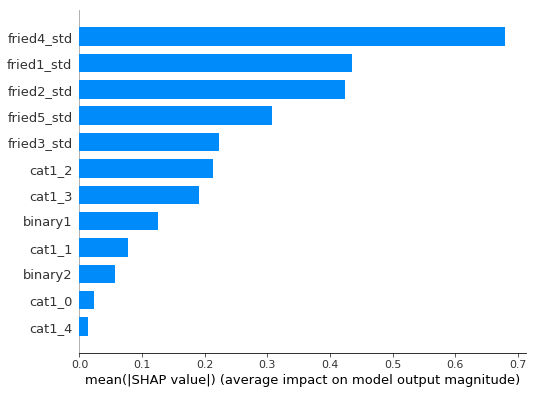

In [11]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

# Shapley for GBM on Test Set

In [12]:
shap_values_gbm, expected_value_gbm = get_shapley(gbm, test, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
-0.0893225,-0.0487418,0.0147183,-0.0728471,-0.621999,-0.113588,0.0075264,0.566437,-0.145626,0.296387,-0.93045,-0.180488,-0.00362614
0.0811356,-0.0966885,0.0234772,-0.0478387,0.164089,0.156076,0.0195588,-1.16048,0.372563,-0.374295,-1.22664,0.0232824,-0.00362614
0.0975231,0.221509,0.0111601,-0.0710076,-0.524915,-0.212273,0.00748339,-0.95076,0.0135714,-0.243608,0.120417,-0.0583782,-0.00362614
0.0828555,0.167824,0.0132267,-0.0430008,0.137913,0.21037,0.026687,-0.782176,0.376948,0.591747,-0.911631,-0.547044,-0.00362614
0.0679384,-0.101527,0.0102497,-0.039741,0.0911671,0.146801,0.0210594,-1.49028,0.295269,0.265616,-1.31976,-0.550835,-0.00362614


In [13]:
# Write MGBM Shapley frame to disk
gbm_shapley = pd.DataFrame(shap_values_gbm, columns=X)
gbm_shapley['bias'] = expected_value_gbm
gbm_shapley.head()
gbm_shapley.to_csv('../data/output/gbm_sim_shapley.csv')

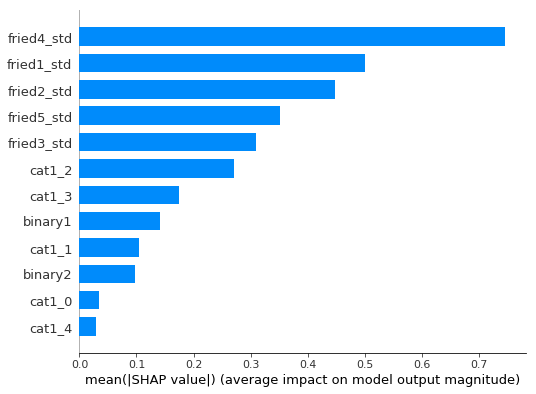

In [14]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

# PDP/ICE for Top 3 Variables from MGBM Global Shapley

## fried4

In [21]:
par_dep_fried4_mgbm = par_dep('fried4_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried4_std  partial_dependence
0    -1.730133            0.245617
1    -1.557029            0.255461
2    -1.383925            0.270163
3    -1.210821            0.285619
4    -1.037717            0.302774
5    -0.864613            0.331936
6    -0.691509            0.364313
7    -0.518405            0.401323
8    -0.345301            0.432375
9    -0.172197            0.450611
10    0.000907            0.484906
11    0.174011            0.541383
12    0.347114            0.573402
13    0.520218            0.602272
14    0.693322            0.624129
15    0.866426            0.670274
16    1.039530            0.681530
17    1.212634            0.713516
18    1.385738            0.731412
19    1.558842            0.744247


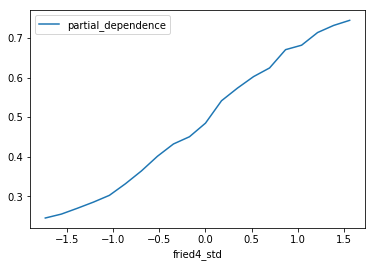

In [22]:
par_dep_fried4_mgbm.plot.line(x='fried4_std', y='partial_dependence')
print(par_dep_fried4_mgbm)

In [23]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried4_mgbm['fried4_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried4_mgbm[col_name] = par_dep('fried4_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried4_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried4_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.730133,0.245617,0.004033,0.090699,0.158680,0.198924,0.123746,0.257449,0.106751,0.201667,0.295886,0.366402,0.738580
1,-1.557029,0.255461,0.005060,0.096841,0.168843,0.213404,0.129686,0.279854,0.113220,0.237425,0.308581,0.384705,0.743698
2,-1.383925,0.270163,0.005845,0.101705,0.171370,0.244715,0.146296,0.304987,0.126757,0.259802,0.322712,0.405020,0.766747
3,-1.210821,0.285619,0.006621,0.109823,0.186565,0.262235,0.151208,0.326249,0.154009,0.278297,0.335600,0.425339,0.796567
4,-1.037717,0.302774,0.007151,0.112286,0.201662,0.277910,0.166396,0.352945,0.162629,0.297334,0.352783,0.448648,0.852572
5,-0.864613,0.331936,0.007901,0.122346,0.238387,0.289311,0.184116,0.402911,0.187995,0.332113,0.408740,0.491657,0.892223
6,-0.691509,0.364313,0.010131,0.144733,0.254240,0.338239,0.218894,0.439431,0.208351,0.367712,0.434197,0.520194,0.904848
7,-0.518405,0.401323,0.013604,0.165396,0.286324,0.375762,0.235563,0.500354,0.275001,0.418157,0.499313,0.574929,0.920636
8,-0.345301,0.432375,0.017104,0.171425,0.300681,0.415834,0.261846,0.547322,0.301847,0.464583,0.532438,0.609210,0.929490
9,-0.172197,0.450611,0.021364,0.184307,0.318098,0.440933,0.277860,0.570661,0.312974,0.490926,0.550736,0.633608,0.937643


In [24]:
# Write PDP + ICE frame to disk
par_dep_fried4_mgbm.to_csv('../data/output/mgbm_sim_fried4_pdp_ice.csv')

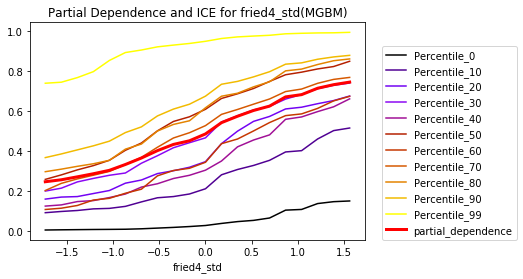

In [25]:
fig, ax = plt.subplots()
par_dep_fried4_mgbm.drop('partial_dependence', axis=1).plot(x='fried4_std', colormap='gnuplot', ax=ax)

par_dep_fried4_mgbm.plot(title='Partial Dependence and ICE for fried4_std(MGBM)',
                         x='fried4_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried1

In [26]:
par_dep_fried1_mgbm = par_dep('fried1_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried1_std  partial_dependence
0    -1.733511            0.247962
1    -1.560081            0.260307
2    -1.386651            0.303189
3    -1.213222            0.330038
4    -1.039792            0.384051
5    -0.866362            0.445677
6    -0.692933            0.471240
7    -0.519503            0.486791
8    -0.346073            0.521841
9    -0.172644            0.546131
10    0.000786            0.570588
11    0.174216            0.578229
12    0.347646            0.593205
13    0.521075            0.604052
14    0.694505            0.608688
15    0.867935            0.611478
16    1.041364            0.618334
17    1.214794            0.619965
18    1.388224            0.624006
19    1.561654            0.626044


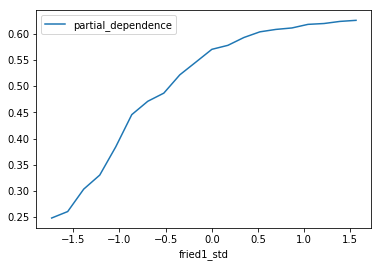

In [27]:
par_dep_fried1_mgbm.plot.line(x='fried1_std', y='partial_dependence')
print(par_dep_fried1_mgbm)

In [28]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried1_mgbm['fried1_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried1_mgbm[col_name] = par_dep('fried1_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried1_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried1_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733511,0.247962,0.003832,0.119636,0.034276,0.088002,0.086109,0.059757,0.514410,0.219876,0.543902,0.508593,0.899298
1,-1.560081,0.260307,0.004064,0.120156,0.040507,0.095111,0.094902,0.070101,0.532785,0.247064,0.552625,0.529432,0.905577
2,-1.386651,0.303189,0.006530,0.135168,0.057777,0.118115,0.135734,0.107032,0.609803,0.313802,0.587828,0.578056,0.914340
3,-1.213222,0.330038,0.008060,0.171357,0.072570,0.133520,0.155903,0.138922,0.623172,0.349846,0.621283,0.604078,0.915527
4,-1.039792,0.384051,0.010209,0.219841,0.102974,0.167906,0.223787,0.200678,0.713122,0.442573,0.682371,0.653165,0.938778
5,-0.866362,0.445677,0.016490,0.305625,0.160639,0.220748,0.279477,0.273147,0.784528,0.508553,0.743769,0.718843,0.948261
6,-0.692933,0.471240,0.019871,0.349749,0.189427,0.247584,0.322425,0.298828,0.806124,0.544233,0.783128,0.745902,0.953512
7,-0.519503,0.486791,0.024929,0.364549,0.211622,0.258887,0.331889,0.306050,0.818306,0.552711,0.790031,0.745902,0.956865
8,-0.346073,0.521841,0.033943,0.416208,0.255025,0.295089,0.339837,0.344792,0.848449,0.580169,0.818010,0.768798,0.965935
9,-0.172644,0.546131,0.037756,0.449593,0.275631,0.319323,0.367404,0.388008,0.871343,0.607287,0.841641,0.792110,0.974424


In [29]:
# Write PDP + ICE frame to disk
par_dep_fried1_mgbm.to_csv('../data/output/mgbm_sim_fried1_pdp_ice.csv')

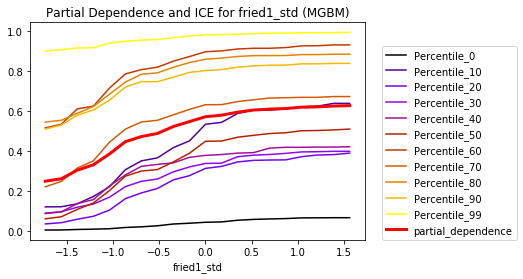

In [30]:
fig, ax = plt.subplots()
par_dep_fried1_mgbm.drop('partial_dependence', axis=1).plot(x='fried1_std', colormap='gnuplot', ax=ax)

par_dep_fried1_mgbm.plot(title='Partial Dependence and ICE for fried1_std (MGBM)',
                         x='fried1_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried2

In [31]:
par_dep_fried2_mgbm = par_dep('fried2_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried2_std  partial_dependence
0    -1.733854            0.245022
1    -1.560647            0.269151
2    -1.387441            0.294583
3    -1.214235            0.339864
4    -1.041028            0.391105
5    -0.867822            0.446719
6    -0.694615            0.467293
7    -0.521409            0.498642
8    -0.348203            0.527151
9    -0.174996            0.551875
10   -0.001790            0.571177
11    0.171417            0.574062
12    0.344623            0.581568
13    0.517829            0.591264
14    0.691036            0.600342
15    0.864242            0.603909
16    1.037449            0.606418
17    1.210655            0.609783
18    1.383861            0.611696
19    1.557068            0.613464


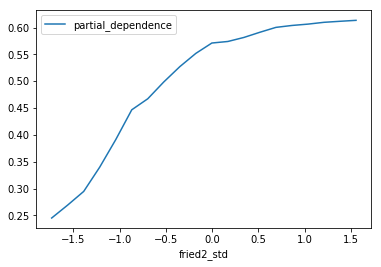

In [32]:
par_dep_fried2_mgbm.plot.line(x='fried2_std', y='partial_dependence')
print(par_dep_fried2_mgbm)

In [33]:
quantile_dict_mgbm = get_quantile_dict('outcome_mgbm_pred', 'Id', test)
bins = list(par_dep_fried2_mgbm['fried2_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried2_mgbm[col_name] = par_dep('fried2_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried2_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried2_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733854,0.245022,0.001817,0.020031,0.044310,0.155168,0.377918,0.177412,0.187218,0.321023,0.353921,0.547198,0.855042
1,-1.560647,0.269151,0.002087,0.022946,0.051029,0.167162,0.418994,0.211029,0.228000,0.381227,0.408034,0.576294,0.871149
2,-1.387441,0.294583,0.002895,0.030044,0.052940,0.183452,0.435974,0.226672,0.255995,0.423834,0.456518,0.618658,0.906209
3,-1.214235,0.339864,0.004388,0.039867,0.066762,0.230322,0.528386,0.298601,0.322450,0.473196,0.516305,0.655828,0.943875
4,-1.041028,0.391105,0.005901,0.048206,0.081387,0.267775,0.672881,0.369033,0.388000,0.552355,0.585574,0.718903,0.965688
5,-0.867822,0.446719,0.007690,0.065139,0.094255,0.307844,0.747703,0.457613,0.441291,0.623017,0.641265,0.797914,0.977903
6,-0.694615,0.467293,0.009015,0.074710,0.115524,0.338239,0.777822,0.500354,0.449557,0.654336,0.665242,0.808677,0.980596
7,-0.521409,0.498642,0.010940,0.093302,0.144054,0.379201,0.832958,0.549680,0.503320,0.679181,0.695332,0.824714,0.983390
8,-0.348203,0.527151,0.015089,0.116786,0.159710,0.416043,0.869336,0.597764,0.512889,0.693072,0.716678,0.841568,0.988776
9,-0.174996,0.551875,0.018215,0.131104,0.198708,0.448656,0.891387,0.633587,0.537435,0.723857,0.729921,0.860457,0.990624


In [34]:
# Write PDP + ICE frame to disk
par_dep_fried2_mgbm.to_csv('../data/output/mgbm_sim_fried2_pdp_ice.csv')

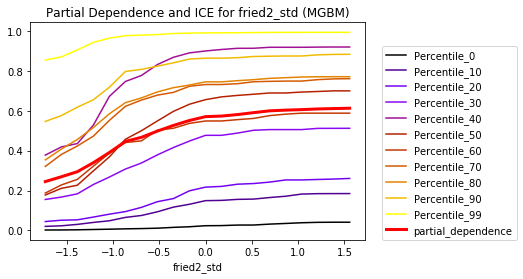

In [35]:
fig, ax = plt.subplots()
par_dep_fried2_mgbm.drop('partial_dependence', axis=1).plot(x='fried2_std', colormap='gnuplot', ax=ax)

par_dep_fried2_mgbm.plot(title='Partial Dependence and ICE for fried2_std (MGBM)',
                         x='fried2_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

# PDP/ICE for Top 3 Variables from GBM Global Shapley

## fried4

In [36]:
par_dep_fried4_gbm = par_dep('fried4_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried4_std  partial_dependence
0    -1.730133            0.216415
1    -1.557029            0.231008
2    -1.383925            0.252398
3    -1.210821            0.276751
4    -1.037717            0.294661
5    -0.864613            0.324322
6    -0.691509            0.361851
7    -0.518405            0.398009
8    -0.345301            0.421905
9    -0.172197            0.444459
10    0.000907            0.486284
11    0.174011            0.542121
12    0.347114            0.570606
13    0.520218            0.603146
14    0.693322            0.627009
15    0.866426            0.665118
16    1.039530            0.683594
17    1.212634            0.717590
18    1.385738            0.742246
19    1.558842            0.759431


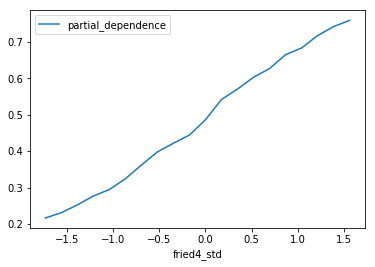

In [37]:
par_dep_fried4_gbm.plot.line(x='fried4_std', y='partial_dependence')
print(par_dep_fried4_gbm)

In [38]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried4_gbm['fried4_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried4_gbm[col_name] = par_dep('fried4_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried4_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried4_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.730133,0.216415,0.014999,0.110018,0.131673,0.118754,0.124690,0.075995,0.244367,0.164325,0.113913,0.614118,0.832640
1,-1.557029,0.231008,0.014769,0.110551,0.149795,0.131335,0.142698,0.084667,0.291197,0.171011,0.123824,0.629031,0.838763
2,-1.383925,0.252398,0.016220,0.120305,0.168338,0.150102,0.152542,0.091744,0.337356,0.180792,0.132898,0.711545,0.887357
3,-1.210821,0.276751,0.016975,0.139543,0.195643,0.148418,0.164389,0.098624,0.373365,0.206328,0.175500,0.722401,0.892123
4,-1.037717,0.294661,0.017620,0.149652,0.205269,0.182872,0.173345,0.101885,0.383191,0.233172,0.183145,0.765749,0.903020
5,-0.864613,0.324322,0.017054,0.162263,0.217400,0.189968,0.178051,0.108750,0.452890,0.281551,0.204300,0.805882,0.921760
6,-0.691509,0.361851,0.018179,0.187560,0.255851,0.243124,0.197000,0.126523,0.488565,0.289965,0.236116,0.847638,0.938370
7,-0.518405,0.398009,0.019696,0.235150,0.280375,0.289133,0.245377,0.139876,0.580334,0.329993,0.275320,0.862396,0.945457
8,-0.345301,0.421905,0.021431,0.248238,0.310772,0.288976,0.256084,0.160694,0.586397,0.340594,0.296969,0.863769,0.949774
9,-0.172197,0.444459,0.023509,0.284477,0.332830,0.315158,0.265732,0.171080,0.606007,0.371368,0.324285,0.876975,0.952457


In [39]:
# Write PDP + ICE frame to disk
par_dep_fried4_gbm.to_csv('../data/output/gbm_sim_fried4_pdp_ice.csv')

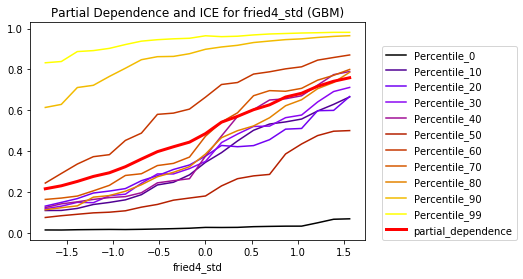

In [40]:
fig, ax = plt.subplots()
par_dep_fried4_gbm.drop('partial_dependence', axis=1).plot(x='fried4_std', colormap='gnuplot', ax=ax)

par_dep_fried4_gbm.plot(title='Partial Dependence and ICE for fried4_std (GBM)',
                         x='fried4_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried1

In [41]:
par_dep_fried1_gbm = par_dep('fried1_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried1_std  partial_dependence
0    -1.733511            0.206741
1    -1.560081            0.225890
2    -1.386651            0.283497
3    -1.213222            0.325443
4    -1.039792            0.375518
5    -0.866362            0.436484
6    -0.692933            0.464556
7    -0.519503            0.484509
8    -0.346073            0.518656
9    -0.172644            0.543577
10    0.000786            0.569664
11    0.174216            0.579457
12    0.347646            0.592970
13    0.521075            0.612238
14    0.694505            0.619404
15    0.867935            0.628722
16    1.041364            0.632711
17    1.214794            0.634986
18    1.388224            0.638601
19    1.561654            0.640505


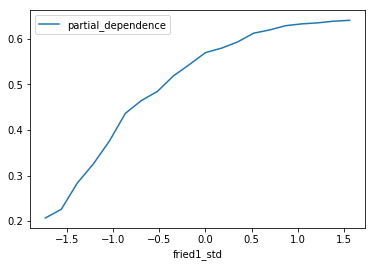

In [42]:
par_dep_fried1_gbm.plot.line(x='fried1_std', y='partial_dependence')
print(par_dep_fried1_gbm)

In [43]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried1_gbm['fried1_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried1_gbm[col_name] = par_dep('fried1_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried1_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried1_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733511,0.206741,0.014083,0.107045,0.045506,0.106974,0.353610,0.202310,0.093428,0.687713,0.281845,0.238138,0.858250
1,-1.560081,0.225890,0.014083,0.129633,0.045506,0.109657,0.438369,0.229960,0.117433,0.753265,0.283535,0.250689,0.889928
2,-1.386651,0.283497,0.016746,0.157724,0.054934,0.175978,0.573324,0.302858,0.158906,0.822472,0.408308,0.325401,0.911316
3,-1.213222,0.325443,0.017533,0.209287,0.057559,0.233177,0.674694,0.395781,0.190538,0.869125,0.460432,0.353045,0.899889
4,-1.039792,0.375518,0.019602,0.298075,0.067134,0.289133,0.752725,0.403263,0.229123,0.905786,0.584867,0.463555,0.932206
5,-0.866362,0.436484,0.020816,0.444439,0.085771,0.432776,0.803225,0.451409,0.291307,0.929011,0.645113,0.623463,0.943345
6,-0.692933,0.464556,0.021841,0.486156,0.088179,0.442661,0.826761,0.467225,0.336404,0.940573,0.737080,0.691593,0.949911
7,-0.519503,0.484509,0.023447,0.554359,0.098180,0.450095,0.836075,0.477705,0.381846,0.944977,0.750058,0.725445,0.958366
8,-0.346073,0.518656,0.025287,0.592538,0.140322,0.493138,0.860624,0.491840,0.443730,0.956515,0.790056,0.779938,0.958930
9,-0.172644,0.543577,0.026889,0.640017,0.160568,0.534963,0.873936,0.486896,0.570568,0.960957,0.794590,0.818123,0.968373


In [44]:
# Write PDP + ICE frame to disk
par_dep_fried1_gbm.to_csv('../data/output/gbm_sim_fried1_pdp_ice.csv')

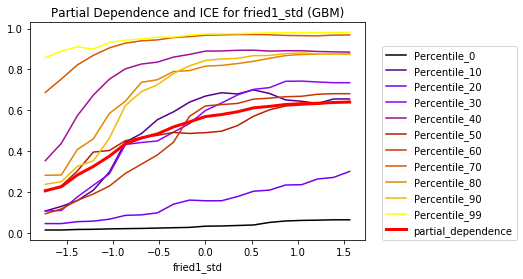

In [45]:
fig, ax = plt.subplots()
par_dep_fried1_gbm.drop('partial_dependence', axis=1).plot(x='fried1_std', colormap='gnuplot', ax=ax)

par_dep_fried1_gbm.plot(title='Partial Dependence and ICE for fried1_std (GBM)',
                         x='fried1_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## fried2

In [46]:
par_dep_fried2_gbm = par_dep('fried2_std', test[X], gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    fried2_std  partial_dependence
0    -1.733854            0.226841
1    -1.560647            0.250580
2    -1.387441            0.279625
3    -1.214235            0.328485
4    -1.041028            0.375489
5    -0.867822            0.435482
6    -0.694615            0.457850
7    -0.521409            0.489327
8    -0.348203            0.518101
9    -0.174996            0.543534
10   -0.001790            0.567367
11    0.171417            0.575985
12    0.344623            0.588602
13    0.517829            0.600907
14    0.691036            0.616189
15    0.864242            0.622251
16    1.037449            0.626350
17    1.210655            0.632258
18    1.383861            0.630902
19    1.557068            0.629808


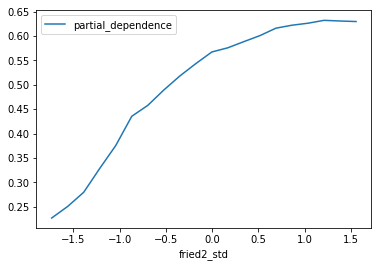

In [47]:
par_dep_fried2_gbm.plot.line(x='fried2_std', y='partial_dependence')
print(par_dep_fried2_gbm)

In [48]:
quantile_dict_gbm = get_quantile_dict('outcome_gbm_pred', 'Id', test)
bins = list(par_dep_fried2_gbm['fried2_std'])
for i in sorted(quantile_dict_gbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_fried2_gbm[col_name] = par_dep('fried2_std', 
                                            test[test['Id'] == int(quantile_dict_gbm[i])][X], 
                                            gbm, 
                                            bins=bins)['partial_dependence']
par_dep_fried2_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,fried2_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.733854,0.226841,0.012491,0.030357,0.061483,0.113766,0.083593,0.338188,0.127283,0.244035,0.426475,0.342544,0.903630
1,-1.560647,0.250580,0.012913,0.034601,0.062104,0.134570,0.098155,0.365474,0.147563,0.291569,0.445398,0.362588,0.917601
2,-1.387441,0.279625,0.012973,0.035930,0.065645,0.132656,0.127755,0.444384,0.118251,0.317445,0.490660,0.445624,0.945366
3,-1.214235,0.328485,0.013850,0.041037,0.070268,0.145486,0.156808,0.517202,0.159115,0.370979,0.568665,0.536084,0.953930
4,-1.041028,0.375489,0.014643,0.045776,0.085625,0.137439,0.170948,0.608010,0.185616,0.428403,0.654503,0.622282,0.969470
5,-0.867822,0.435482,0.015588,0.052762,0.119355,0.146756,0.254047,0.746209,0.278441,0.550298,0.709600,0.686768,0.974073
6,-0.694615,0.457850,0.016371,0.058982,0.166059,0.169512,0.255139,0.754388,0.360958,0.552203,0.738378,0.735309,0.977622
7,-0.521409,0.489327,0.017390,0.063429,0.198734,0.179514,0.278777,0.799946,0.415948,0.585004,0.795273,0.778498,0.977510
8,-0.348203,0.518101,0.019089,0.070376,0.273675,0.235802,0.303022,0.827740,0.446667,0.596783,0.798300,0.838657,0.978775
9,-0.174996,0.543534,0.018851,0.071773,0.347581,0.256990,0.320595,0.859068,0.507962,0.606424,0.843153,0.852382,0.979509


In [49]:
# Write PDP + ICE frame to disk
par_dep_fried2_gbm.to_csv('../data/output/gbm_sim_fried2_pdp_ice.csv')

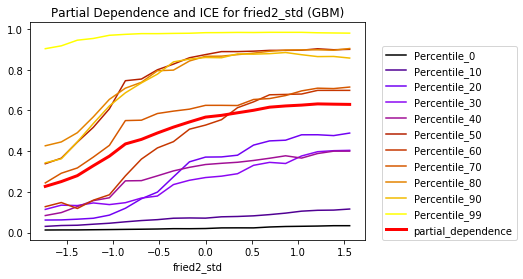

In [50]:
fig, ax = plt.subplots()
par_dep_fried2_gbm.drop('partial_dependence', axis=1).plot(x='fried2_std', colormap='gnuplot', ax=ax)

par_dep_fried2_gbm.plot(title='Partial Dependence and ICE for fried2_std (GBM)',
                         x='fried2_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

# Average Shapley Value Per Decile W.R.T each of the following: fried4_std, fried1_std, and fried2_std for MGBM and GBM

## Gather MGBM and GBM Shapley Frame and Merge Top Three Features from Test Set

In [15]:
shapley_mgbm = mgbm_shapley
shapley_gbm = gbm_shapley

In [16]:
shapley_mgbm.head()

,binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,bias
0,-0.095952,-0.024563,0.005428,-0.047672,-0.537065,-0.166826,0.005372,0.461860,-0.310311,0.218317,-0.811191,-0.253719,-0.645522
1,0.081665,-0.063773,0.015472,-0.024906,0.093403,0.140056,0.013405,-0.959218,0.331540,-0.212922,-1.045531,-0.002997,-0.645522
2,0.096267,0.136779,0.007497,-0.049801,-0.453360,-0.194437,0.005488,-0.815045,0.086892,-0.158499,0.140201,-0.063248,-0.645522
3,0.094708,0.097632,0.016463,-0.024438,0.084399,0.198923,0.027606,-0.809242,0.378051,0.415138,-0.899323,-0.483465,-0.645522
4,0.084155,-0.077035,0.018484,-0.021747,0.062465,0.169482,0.032945,-1.231355,0.398239,0.281522,-1.120006,-0.503518,-0.645522


In [17]:
shapley_gbm.head()

,binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,bias
0,-0.089323,-0.048742,0.014718,-0.072847,-0.621999,-0.113588,0.007526,0.566437,-0.145626,0.296387,-0.930450,-0.180488,-0.811127
1,0.081136,-0.096688,0.023477,-0.047839,0.164089,0.156076,0.019559,-1.160475,0.372563,-0.374295,-1.226637,0.023282,-0.811127
2,0.097523,0.221509,0.011160,-0.071008,-0.524915,-0.212273,0.007483,-0.950760,0.013571,-0.243608,0.120417,-0.058378,-0.811127
3,0.082856,0.167824,0.013227,-0.043001,0.137913,0.210370,0.026687,-0.782176,0.376948,0.591747,-0.911631,-0.547044,-0.811127
4,0.067938,-0.101527,0.010250,-0.039741,0.091167,0.146801,0.021059,-1.490285,0.295269,0.265616,-1.319762,-0.550835,-0.811127


In [18]:
shapley_mgbm['fried4_std_from_test'] = test['fried4_std'].as_data_frame()
shapley_mgbm['fried1_std_from_test'] = test['fried1_std'].as_data_frame()
shapley_mgbm['fried2_std_from_test'] = test['fried2_std'].as_data_frame()

In [19]:
shapley_mgbm.head()

,binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,bias,fried4_std_from_test,fried1_std_from_test,fried2_std_from_test
0,-0.095952,-0.024563,0.005428,-0.047672,-0.537065,-0.166826,0.005372,0.461860,-0.310311,0.218317,-0.811191,-0.253719,-0.645522,-0.845874,1.214478,-0.757816
1,0.081665,-0.063773,0.015472,-0.024906,0.093403,0.140056,0.013405,-0.959218,0.331540,-0.212922,-1.045531,-0.002997,-0.645522,-1.557939,-1.425365,1.152062
2,0.096267,0.136779,0.007497,-0.049801,-0.453360,-0.194437,0.005488,-0.815045,0.086892,-0.158499,0.140201,-0.063248,-0.645522,0.069928,-1.295574,-0.168411
3,0.094708,0.097632,0.016463,-0.024438,0.084399,0.198923,0.027606,-0.809242,0.378051,0.415138,-0.899323,-0.483465,-0.645522,-1.236144,-1.248210,1.585072
4,0.084155,-0.077035,0.018484,-0.021747,0.062465,0.169482,0.032945,-1.231355,0.398239,0.281522,-1.120006,-0.503518,-0.645522,-1.678840,-1.677053,1.646148


In [20]:
shapley_gbm['fried4_std_from_test'] = test['fried4_std'].as_data_frame()
shapley_gbm['fried1_std_from_test'] = test['fried1_std'].as_data_frame()
shapley_gbm['fried2_std_from_test'] = test['fried2_std'].as_data_frame()

In [21]:
shapley_gbm.head()

,binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,bias,fried4_std_from_test,fried1_std_from_test,fried2_std_from_test
0,-0.089323,-0.048742,0.014718,-0.072847,-0.621999,-0.113588,0.007526,0.566437,-0.145626,0.296387,-0.930450,-0.180488,-0.811127,-0.845874,1.214478,-0.757816
1,0.081136,-0.096688,0.023477,-0.047839,0.164089,0.156076,0.019559,-1.160475,0.372563,-0.374295,-1.226637,0.023282,-0.811127,-1.557939,-1.425365,1.152062
2,0.097523,0.221509,0.011160,-0.071008,-0.524915,-0.212273,0.007483,-0.950760,0.013571,-0.243608,0.120417,-0.058378,-0.811127,0.069928,-1.295574,-0.168411
3,0.082856,0.167824,0.013227,-0.043001,0.137913,0.210370,0.026687,-0.782176,0.376948,0.591747,-0.911631,-0.547044,-0.811127,-1.236144,-1.248210,1.585072
4,0.067938,-0.101527,0.010250,-0.039741,0.091167,0.146801,0.021059,-1.490285,0.295269,0.265616,-1.319762,-0.550835,-0.811127,-1.678840,-1.677053,1.646148


## Average Shapley Value Per Decile W.R.T each of the following: loan_to_value_ratio_std, debt_to_income_ratio_std, and property_value_std for MGBM


fried4_std_from_test
(-1.7309999999999999, -1.389]   -1.068209
(-1.389, -1.038]                -0.929821
(-1.038, -0.685]                -0.690554
(-0.685, -0.335]                -0.416267
(-0.335, 0.0102]                -0.174218
(0.0102, 0.356]                  0.189973
(0.356, 0.705]                   0.447886
(0.705, 1.054]                   0.730045
(1.054, 1.392]                   0.970448
(1.392, 1.732]                   1.161269
Name: fried4_std, dtype: float64


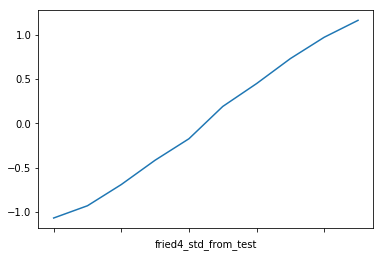

In [22]:
shapley_mgbm_fried4_agg = shapley_mgbm.groupby(pd.qcut(shapley_mgbm.fried4_std_from_test, 10, duplicates='drop'))['fried4_std'].mean()
print(shapley_mgbm_fried4_agg)
shapley_mgbm_fried4_agg.plot()

fried1_std_from_test
(-1.7349999999999999, -1.389]   -1.117298
(-1.389, -1.042]                -0.704898
(-1.042, -0.691]                -0.293566
(-0.691, -0.34]                 -0.046622
(-0.34, 0.00804]                 0.153336
(0.00804, 0.355]                 0.297981
(0.355, 0.714]                   0.396401
(0.714, 1.052]                   0.425257
(1.052, 1.397]                   0.440090
(1.397, 1.735]                   0.434091
Name: fried1_std, dtype: float64


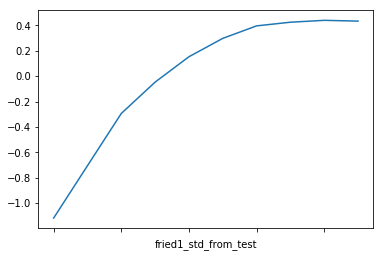

In [23]:
shapley_mgbm_fried1_agg = shapley_mgbm.groupby(pd.qcut(shapley_mgbm.fried1_std_from_test, 10, duplicates='drop'))['fried1_std'].mean()
print(shapley_mgbm_fried1_agg)
shapley_mgbm_fried1_agg.plot()

fried2_std_from_test
(-1.7349999999999999, -1.397]   -1.099127
(-1.397, -1.054]                -0.735705
(-1.054, -0.703]                -0.345743
(-0.703, -0.352]                -0.052393
(-0.352, -0.00856]               0.167370
(-0.00856, 0.333]                0.272042
(0.333, 0.682]                   0.332187
(0.682, 1.027]                   0.384730
(1.027, 1.379]                   0.395458
(1.379, 1.73]                    0.397155
Name: fried2_std, dtype: float64


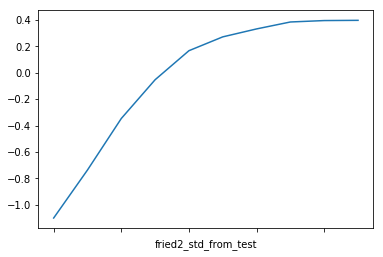

In [24]:
shapley_mgbm_fried2_agg = shapley_mgbm.groupby(pd.qcut(shapley_mgbm.fried2_std_from_test, 10, duplicates='drop'))['fried2_std'].mean()
print(shapley_mgbm_fried2_agg)
shapley_mgbm_fried2_agg.plot()

## Average Shapley Value Per Decile W.R.T each of the following: loan_to_value_ratio_std, debt_to_income_ratio_std, and property_value_std for GBM

fried4_std_from_test
(-1.7309999999999999, -1.389]   -1.245904
(-1.389, -1.038]                -1.042689
(-1.038, -0.685]                -0.760703
(-0.685, -0.335]                -0.460489
(-0.335, 0.0102]                -0.191335
(0.0102, 0.356]                  0.190912
(0.356, 0.705]                   0.462101
(0.705, 1.054]                   0.753600
(1.054, 1.392]                   1.029826
(1.392, 1.732]                   1.291549
Name: fried4_std, dtype: float64


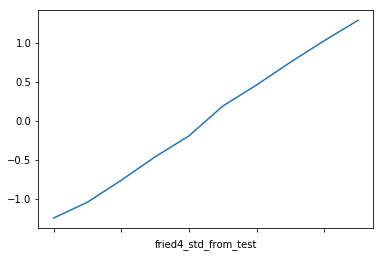

In [25]:
shapley_gbm_fried4_agg = shapley_gbm.groupby(pd.qcut(shapley_gbm.fried4_std_from_test, 10, duplicates='drop'))['fried4_std'].mean()
print(shapley_gbm_fried4_agg)
shapley_gbm_fried4_agg.plot()

fried1_std_from_test
(-1.7349999999999999, -1.389]   -1.277905
(-1.389, -1.042]                -0.757646
(-1.042, -0.691]                -0.323988
(-0.691, -0.34]                 -0.052865
(-0.34, 0.00804]                 0.159119
(0.00804, 0.355]                 0.325069
(0.355, 0.714]                   0.453550
(0.714, 1.052]                   0.524842
(1.052, 1.397]                   0.541614
(1.397, 1.735]                   0.484602
Name: fried1_std, dtype: float64


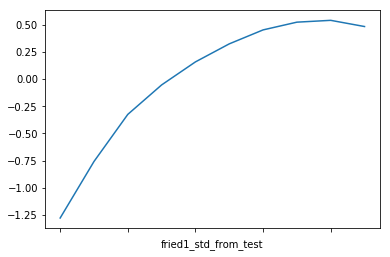

In [26]:
shapley_gbm_fried1_agg = shapley_gbm.groupby(pd.qcut(shapley_gbm.fried1_std_from_test, 10, duplicates='drop'))['fried1_std'].mean()
print(shapley_gbm_fried1_agg)
shapley_gbm_fried1_agg.plot()

fried2_std_from_test
(-1.7349999999999999, -1.397]   -1.137376
(-1.397, -1.054]                -0.723379
(-1.054, -0.703]                -0.324340
(-0.703, -0.352]                -0.031089
(-0.352, -0.00856]               0.166742
(-0.00856, 0.333]                0.286549
(0.333, 0.682]                   0.365563
(0.682, 1.027]                   0.452361
(1.027, 1.379]                   0.468803
(1.379, 1.73]                    0.414624
Name: fried2_std, dtype: float64


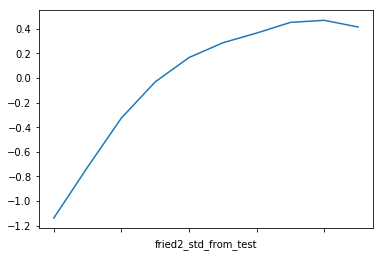

In [27]:
shapley_gbm_fried2_agg = shapley_gbm.groupby(pd.qcut(shapley_gbm.fried2_std_from_test, 10, duplicates='drop'))['fried2_std'].mean()
print(shapley_gbm_fried2_agg)
shapley_gbm_fried2_agg.plot()